In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, pathlib
import random, math

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

### Data loading

In [2]:
cur_dir = '/home/pc/Desktop_linux/chinu/big_mart_sales_prediction/'
os.chdir(cur_dir)
df_path = 'train_v9rqX0R.csv'
unseen_path = 'test_AbJTz2l.csv'

df = pd.read_csv(df_path)
unseen_df = pd.read_csv(unseen_path)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.head())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales
0           FDA15         9.30          Low Fat         0.016047                  Dairy  249.8092            OUT049                       1999      Medium               Tier 1  Supermarket Type1          3735.1380
1           DRC01         5.92          Regular         0.019278            Soft Drinks   48.2692            OUT018                       2009      Medium               Tier 3  Supermarket Type2           443.4228
2           FDN15        17.50          Low Fat         0.016760                   Meat  141.6180            OUT049                       1999      Medium               Tier 1  Supermarket Type1          2097.2700
3           FDX07        19.20          Regular         0.000000  Fruits and Vegetables  182.0950            OUT010                       1998  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Missing Values

In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
unseen_df.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

### Create Item weights DF for each item

In [6]:
df_weights = df[['Item_Identifier', 'Item_Weight']].dropna(axis=0)
df_weights = df_weights.groupby(by='Item_Identifier')['Item_Weight'].apply(lambda x: x.mode().iloc[0]).reset_index()
df_weights.head()

df_Item_Identifier = df.groupby(by='Item_Identifier')['Item_Outlet_Sales'].mean().reset_index()

### Give scores to outlet

In [7]:
df_outlet = df.groupby(by='Outlet_Identifier')['Item_Outlet_Sales'].mean().reset_index()

#### Remove 0 visibility rows

In [8]:
df = df[df['Item_Visibility'] > 0]

### Data Preprocessing 

In [9]:
GROCERY_STORE_SIZE = df[df['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].dropna().unique()[0]
LOCATION_TIER_2_SIZE = df[df['Outlet_Location_Type'] == 'Tier 2']['Outlet_Size'].dropna().unique()[0]
avg_visibility = df[df['Item_Visibility'] > 0]['Item_Visibility'].mean()
avg_log_visibility = df[df['Item_Visibility'] > 0]['Item_Visibility'].apply(lambda x: math.log(x * 1000 + 1)).mean()


def preprocess_data(row):
    if pd.isna(row['Item_Weight']):
        mode_val = df_weights.loc[df_weights['Item_Identifier'] == row['Item_Identifier'], 'Item_Weight'] 
        if not mode_val.empty:
            row['Item_Weight'] = mode_val.iloc[0]
            
    if pd.isna(row['Outlet_Size']):
        if row['Outlet_Type'] == 'Grocery Store':
            row['Outlet_Size'] = GROCERY_STORE_SIZE
        elif row['Outlet_Location_Type'] == 'Tier 2':
            row['Outlet_Size'] = LOCATION_TIER_2_SIZE
    
    # assign 1 for low fat else 0
    my_dict = {'Low Fat' : 1,
               'Regular' : 0,
               'LF' : 1,
               'reg' : 0,
               'low fat' : 1}
    row['Item_Fat_Content'] = my_dict[row['Item_Fat_Content']]

    # Feature enginnering for establish_year
    row['Outlet_Total_Years'] = int(2013 - row['Outlet_Establishment_Year'])

    # Handle Visibility feature
    row['Item_Visibility'] = row['Item_Visibility'] + avg_visibility
    row['MRP_mul_Item_Vis_log'] = (math.log(row['Item_Visibility'] * 1000 + 1) + avg_log_visibility) * row['Item_MRP']

    # Target Encoding for Item_Identifier
    row['Item_Identifier_encoded'] = df_Item_Identifier.loc[df_Item_Identifier['Item_Identifier'] == row['Item_Identifier'], 'Item_Outlet_Sales'].iloc[0]

    # Score the outlet
    row['Outlet_Score'] = df_outlet.loc[df_outlet['Outlet_Identifier'] == row['Outlet_Identifier'], 'Item_Outlet_Sales'].iloc[0]
    
    return row





drop_columns = ['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_Identifier_encoded', 'Outlet_Establishment_Year', 'Outlet_Identifier']

df_clean = df.apply(preprocess_data, axis=1)
unseen_df_clean = unseen_df.apply(preprocess_data, axis=1)

df_clean['Item_Weight'] = df_clean['Item_Weight'].fillna(df_clean['Item_Weight'].mode().iloc[0])
unseen_df_clean['Item_Weight'] = unseen_df_clean['Item_Weight'].fillna(df_clean['Item_Weight'].mode().iloc[0])

df_clean = df_clean.drop(drop_columns, axis=1)
unseen_df_clean = unseen_df_clean.drop(drop_columns, axis=1)

df_clean.isna().sum()


Item_Fat_Content        0
Item_Type               0
Item_MRP                0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
Outlet_Total_Years      0
MRP_mul_Item_Vis_log    0
Outlet_Score            0
dtype: int64

### Correlation

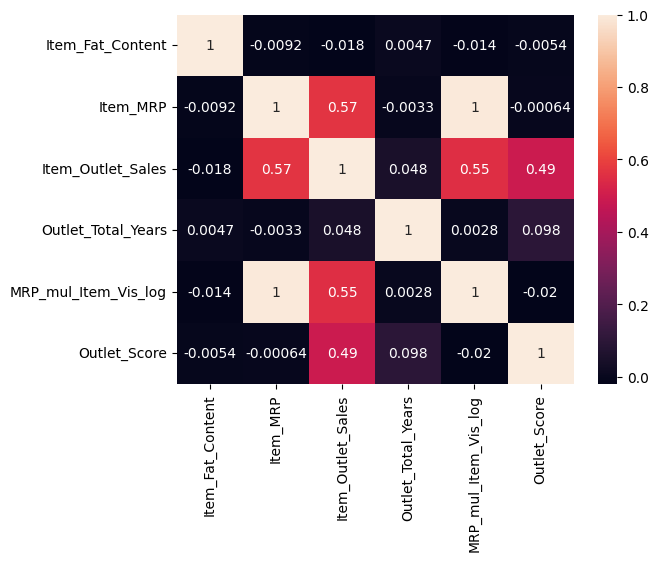

In [10]:
cat_col = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type']
num_col = [feature for feature in df_clean.columns.to_list() if feature not in cat_col]


cols = ['Outlet_Score','Item_Outlet_Sales']
plt.Figure(figsize=(500, 500))
sns.heatmap(df_clean[num_col].corr(), annot=True)
plt.show()

### One hot encoding for Categorical Variables

In [11]:
def one_hot_encoding(temp_df):
    dummies = pd.get_dummies(temp_df[cat_col], dtype=int)
    new_df = pd.concat([temp_df, dummies], axis=1)
    new_df = new_df.drop(cat_col, axis=1)
    return new_df


df_clean = one_hot_encoding(df_clean)
unseen_df_clean = one_hot_encoding(unseen_df_clean)

### Visualization

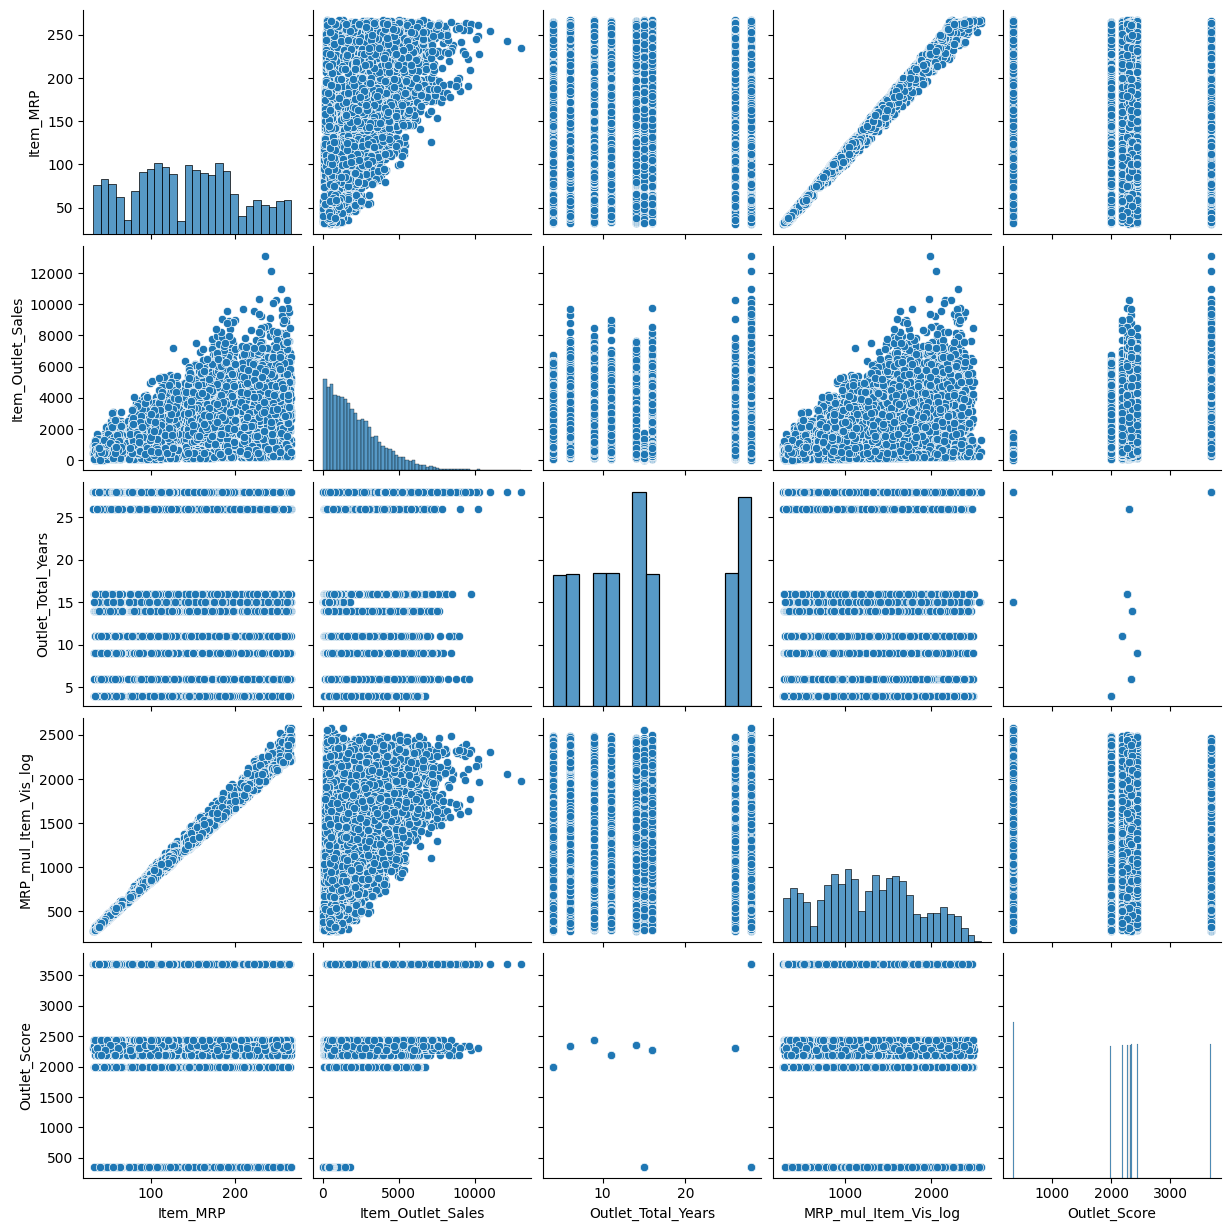

In [12]:
sns.pairplot(df_clean[['Item_MRP', 'Item_Outlet_Sales', 'Outlet_Total_Years', 'MRP_mul_Item_Vis_log', 'Outlet_Score']])
plt.show()

### Train- Test Split

In [13]:
y = df_clean['Item_Outlet_Sales']
X = df_clean.drop(['Item_Outlet_Sales'], axis=1)
X_unseen = unseen_df_clean.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_unseen.shape

((7597, 31), (400, 31), (7597,), (400,), (5681, 31))

### Scalling

In [14]:
scaler = MinMaxScaler()
scaling_col = X_train.columns.to_list()
X_train[scaling_col] = scaler.fit_transform(X_train[scaling_col])
X_test[scaling_col] = scaler.transform(X_test[scaling_col])
X_unseen[scaling_col] = scaler.transform(X_unseen[scaling_col])
X_train.head()

,Item_Fat_Content,Item_MRP,Outlet_Total_Years,MRP_mul_Item_Vis_log,Outlet_Score,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
420,1.0,0.283180,0.458333,0.251259,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
733,1.0,0.375299,0.291667,0.354319,0.552371,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,1.0,0.512499,1.000000,0.466392,0.000292,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5239,1.0,0.304939,0.000000,0.264497,0.493682,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1529,0.0,0.597011,0.500000,0.580335,0.577846,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Model Evaluation

In [17]:
def model_evaluation(y_train, y_train_pred, y_test, y_test_pred, model='Regression'):
    print("*" * 80)
    print("*" * 30, model, '*' * 30)
    print("*" * 80)
    print('Train Data : ')
    print('RMSE = ', root_mean_squared_error(y_train, y_train_pred))
    print('R2_score = ', r2_score(y_train, y_train_pred))
    print('\n\nTest Data : ')
    print('RMSE = ', root_mean_squared_error(y_test, y_test_pred))
    print('R2_score = ', r2_score(y_test, y_test_pred))


### XGBoosting

In [20]:
# Define RMSE function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create RMSE scorer for GridSearchCV
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [ 300, 400, 500, 600],
    'learning_rate': [0.003, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=4,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.003, 0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [300, 400, 500, 600],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [21]:
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_xgb_model)
print(best_params)

y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)
y_unseen_pred_xgb = best_xgb_model.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
********************************************************************************
****************************** Regression *************

## Submission File

In [22]:
unseen_path = 'test_AbJTz2l.csv'
unseen_df = pd.read_csv(unseen_path)

submission_df = unseen_df[['Item_Identifier', 'Outlet_Identifier']]
submission_df['Item_Outlet_Sales'] = y_unseen_pred_xgb

write_file_path = 'submission/16th_attempt.csv'
submission_df.to_csv(write_file_path, index=False)

# Back up Strategies

### Random Forest

In [23]:
param = {
    'n_estimators': [ 200, 300, 400, 500, 600],
    'max_depth': [5, 7, 10],
    'min_samples_split': [3, 5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'random_state': [42]
}


rf = RandomForestRegressor()

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# 2. Create the RMSE scorer using make_scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False) 

grid_search = GridSearchCV(estimator=rf,
                           scoring=rmse_scorer,  # Use the scorer here
                           verbose=1,
                           cv=4,
                           param_grid=param,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
print(best_estimator)

y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)
y_unseen_pred_rf = best_estimator.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'RF')

Fitting 4 folds for each of 180 candidates, totalling 720 fits
RandomForestRegressor(max_depth=7, min_samples_leaf=15, min_samples_split=3,
                      n_estimators=400, random_state=42)
********************************************************************************
****************************** RF ******************************
********************************************************************************
Train Data : 
RMSE =  1032.026639221684
R2_score =  0.6344390607606776


Test Data : 
RMSE =  1108.9431563980704
R2_score =  0.5481088659627722


### Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_unseen_pred_lr = lr.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'LR')

********************************************************************************
****************************** LR ******************************
********************************************************************************
Train Data : 
RMSE =  1121.4781939263623
R2_score =  0.5683222779309512


Test Data : 
RMSE =  1108.9431563980704
R2_score =  0.5481088659627722


### Ridge Regression

In [25]:
param = {'alpha': np.logspace(-3, 3, 7)}
ridge = Ridge()

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=ridge,
                           param_grid=param,
                           cv=5,
                           scoring=rmse_scorer,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
print(best_estimator)
y_train_pred = best_estimator.predict(X_train)
y_unseen_pred_ridge = best_estimator.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, best_estimator)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Ridge(alpha=np.float64(0.01))
********************************************************************************
****************************** Ridge(alpha=np.float64(0.01)) ******************************
********************************************************************************
Train Data : 
RMSE =  1121.4783358880948
R2_score =  0.5683221686435456


Test Data : 
RMSE =  1108.9431563980704
R2_score =  0.5481088659627722


### Lasso Regression

In [26]:
param = {'alpha': np.logspace(-3, 3, 7)}
lasso = Lasso()

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=lasso,
                           param_grid=param,
                           cv=5,
                           scoring=rmse_scorer,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
print(best_estimator)
y_train_pred = best_estimator.predict(X_train)
y_unseen_pred_ridge = best_estimator.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, best_estimator)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Lasso(alpha=np.float64(10.0))
********************************************************************************
****************************** Lasso(alpha=np.float64(10.0)) ******************************
********************************************************************************
Train Data : 
RMSE =  1124.9432937863583
R2_score =  0.5656505946744026


Test Data : 
RMSE =  1108.9431563980704
R2_score =  0.5481088659627722


/home/pc/Desktop_linux/chinu/common_kernel/virtual_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+09, tolerance: 1.794e+06
  model = cd_fast.enet_coordinate_descent(
/home/pc/Desktop_linux/chinu/common_kernel/virtual_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+09, tolerance: 1.802e+06
  model = cd_fast.enet_coordinate_descent(
/home/pc/Desktop_linux/chinu/common_kernel/virtual_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

### Target Encoding with KFOLD for 'Item_Identifier'

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df_clean['Item_Identifier_encoded'] = np.nan

for i, (train_index, val_index) in enumerate(kf.split(df_clean)):
    train_df = df_clean.iloc[train_index].copy()  
    val_df = df_clean.iloc[val_index].copy()    
    means = train_df.groupby('Item_Identifier')['Item_Outlet_Sales'].mean().round(2)
    df_clean.loc[val_df.index, 'Item_Identifier_encoded'] = val_df['Item_Identifier'].map(means)


# Calculate mean for overall df_clean
means = df_clean.groupby(by='Item_Identifier')['Item_Outlet_Sales'].mean().round(2)
df_clean['Item_Identifier_encoded'] = df_clean['Item_Identifier_encoded'].fillna(df_clean['Item_Outlet_Sales'].mean().round(2))
unseen_df_clean['Item_Identifier_encoded'] = unseen_df_clean['Item_Identifier'].map(means)